In [1]:
from model import Densenet, Inceptionv3, ResNet, VGG, SimpleCNN, Efficientnet, ResNeSt, Ensemble,SeResNet, Deeplabv3
from model import prunnableResNet
from model.layer.prunableLayer import prunnableConv2D,prunnableLinear
from utils import CovidCTDataset,metrics, SimCLR_loss, LabelSmoothSoftmaxCE
from utils import autoaugment as auto
from torch.utils.data import DataLoader
import argparse
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import torch.nn as nn
import os
import random
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score

from collections import OrderedDict
import matplotlib.pyplot as plt
import easydict

import gc

MODEL_DICT = {
    'densenet121': Densenet.densenet121,
    'densenet161': Densenet.densenet161,
    'densenet169': Densenet.densenet169,
    'densenet201': Densenet.densenet201,
    'resnet18': ResNet.resnet18,
    'resnet50': ResNet.resnet50,
    'resnet101': ResNet.resnet101,
    'resnet152': ResNet.resnet152,
    'seresnet50': SeResNet.se_resnet50,
    'seresnet101': SeResNet.se_resnet101,
    'seresnet152': SeResNet.se_resnet152,
    'resnext101': ResNet.resnext101_32x8d,
    'resnest50': ResNeSt.resnest50,
    'resnest200': ResNeSt.resnest200,
    'wide_resnet101': ResNet.wide_resnet101_2,
    'wide_resnet50': ResNet.wide_resnet50_2,
    'vgg16': VGG.vgg16,
    'CNN': SimpleCNN.CNN,
    'Linear': SimpleCNN.Linear,
    'SimpleCNN': SimpleCNN.SimpleCNN,
    'efficientnet-b7': Efficientnet.efficientnetb7,
    'efficientnet-b1': Efficientnet.efficientnetb1,
    'efficientnet-b0': Efficientnet.efficientnetb0
}

PRUNNABLE_MODEL_DICT={
    'resnet18':prunnableResNet.resnet18,
    'resnet50':prunnableResNet.resnet50,
    'resnet101':prunnableResNet.resnet101,
    'resnet152':prunnableResNet.resnet152
}

def train(model, train_loader, optimizer, PRINT_INTERVAL, epoch, args, device):
    model.train()
    # LOSS_FUNC = LabelSmoothSoftmaxCE()
    LOSS_FUNC = nn.CrossEntropyLoss()
    for index, batch in enumerate(tqdm(train_loader)):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        optimizer.zero_grad()
        loss = LOSS_FUNC(output, label)
        loss.backward()
        optimizer.step()
        if (index + 1) % PRINT_INTERVAL == 0:
            tqdm.write('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
                       % (epoch + 1, args.epoch, index + 1, len(train_loader), loss.item()))

def test(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            output = model(img)
            _, preds = torch.max(output, 1)
            avg_val_loss += F.cross_entropy(output, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(output, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def test_mask(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            cls_pred, mask_pred = model(img)
            _, preds = torch.max(cls_pred, 1)

            avg_val_loss += F.cross_entropy(cls_pred, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(cls_pred, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def convertPaWeights2NonP(pretrained_state_dict):
  nonpStateDict=OrderedDict()
  for k, v in pretrained_state_dict.items():
    nonpStateDict[k[7:]]=v
  return nonpStateDict

def convertStateDict2Prunnable(state_dict):
    prunedStateDict=OrderedDict()
    for k, v in state_dict.items():
        if 'conv' in k or 'downsample.0' in k:
            p=k.find('.weight')
            k=k[:p]+'.conv'+k[p:]
        elif 'fc' in k:
            p=k.find('fc')
            k=k[:p+3]+'linear.'+k[p+3:]
            

        prunedStateDict[k]=v
    return prunedStateDict

models_config = (
    # model name, model path, weight, data_parallel
    ('resnet152', 'resnet152_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('resnet152', 'resnet152_4_4_crop_480_b16w1.2_pretrained.pt', 1, True),
    ('resnext101', 'resnext101_4_4_crop_480_pretrained.pt', 1, True),
    ('densenet169', 'densenet169-480-moco-soft-COVID.pt', 1, True),
    ('densenet169', 'densenet169_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('densenet169', 'densenet169_soft_480_pretrained.pt', 1, True),
)

args = easydict.EasyDict({
    'model_name':'resnet50',
    'checkpoint_path':'./checkpoint/CT',
    'batch_size':16,
    'lr':1e-4,
    'epoch':50,
    'root_dir':'./COVID-CT/Images-processed',

    'train_COV':'./COVID-CT/Data-split/COVID/trainCT_COVID.txt',
    'train_NonCOV':'./COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',

    'val_COV':'./COVID-CT/Data-split/COVID/valCT_COVID.txt',
    'val_NonCOV':'./COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',

    'test_COV':'./COVID-CT/Data-split/COVID/testCT_COVID.txt',
    'test_NonCOV':'./COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',

    'pretrained':True,
    'save_name':'resnet50_pretrained.pt'
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device {}".format(device))
# Create checkpoint file
save_path = os.path.join(args.checkpoint_path, args.model_name)
if os.path.exists(save_path) == False:
    os.makedirs(save_path)

normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                    std=[0.33165374, 0.33165374, 0.33165374])
test_trans = transforms.Compose(
                                [
                                transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                normalize
                                ]
                            )
trainset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.train_COV,
                            txt_NonCOVID=args.train_NonCOV,
                            transform=transforms.Compose(
                                [transforms.RandomResizedCrop((480,480),scale=(0.8,1.2)),
                                    transforms.RandomHorizontalFlip(),
                                    auto.ImageNetPolicy(),
                                    transforms.ToTensor(),
                                    normalize
                                    ]
                            ))
valset = CovidCTDataset(root_dir=args.root_dir,
                        txt_COVID=args.val_COV,
                        txt_NonCOVID=args.val_NonCOV,
                            transform=test_trans
                            )

testset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.test_COV,
                            txt_NonCOVID=args.test_NonCOV,
                            transform=test_trans
                            )

train_loader = DataLoader(trainset,
                            batch_size=args.batch_size,
                            num_workers=8,
                            shuffle=True)
val_loader = DataLoader(valset, batch_size=args.batch_size)
test_loader = DataLoader(testset,batch_size=args.batch_size)

PRINT_INTERVAL = 10
nb_classes = 2
seg_num_class = 2
print(args.model_name,trainset.classes)

model = PRUNNABLE_MODEL_DICT[args.model_name](num_classes=nb_classes, pretrained=args.pretrained)

accs = []
save = os.path.join(save_path,'{}'.format(args.save_name))

print('...........Testing..........')
pretrained_state_dict=torch.load(save, map_location=torch.device('cpu'))
pretrained_state_dict=convertPaWeights2NonP(pretrained_state_dict)
model.load_state_dict(convertStateDict2Prunnable(pretrained_state_dict))

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model).to(device)
elif torch.cuda.device_count() == 1:
    model.to(device)
elif torch.cuda.is_available():
    print("GPU detected but cannot use")


Device cuda
resnet50 ['CT_COVID', 'CT_NonCOVID']
...........Testing..........


In [2]:
cntConv=0
cntDense=0

for m in model.modules():
    if isinstance(m, prunnableConv2D):
        cntConv+=1
    elif isinstance(m, prunnableLinear):
        cntDense+=1
print("In total %d conv, %d dense"%(cntConv,cntDense))

In total 53 conv, 1 dense


In [3]:

ratios=[i/100 for i in range(0,91,10)]
yconvACC,yconvFN=[],[]
ydenseACC,ydenseFN=[],[]
cntConv=-1
for m in model.modules():
    yACC=[]
    yFN=[]
    if isinstance(m, (prunnableConv2D,prunnableLinear)):
        if isinstance(m,prunnableConv2D):
            cntConv+=1
            if cntConv%10!=0:continue
        print(m) 
        for r in ratios:
            m.setPruneRatio(r)
            print('prune ratio:%f'%r)
            AUC, precision, recall, f1, acc, mean_loss = test(model, 2, test_loader, device)
            print('Precision {}\tRecall {}\nF1 {}\nAUC {}\tAcc {}\tMean Loss {}'.format(precision, recall, f1, AUC, acc,
                                                                            mean_loss))
            yACC.append(acc.numpy().tolist())
            yFN.append(recall[1])
            m.resetPruneRatio()
    if isinstance(m,prunnableConv2D):
        yconvACC.append(yACC.copy())
        yconvFN.append(yFN.copy())
    elif isinstance(m,prunnableLinear):
        ydenseACC.append(yACC.copy())
        ydenseFN.append(yFN.copy())

  0%|          | 0/13 [00:00<?, ?it/s]

prunnableConv2D(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [68., 37.]])
Precision [0.9285714  0.35238096]	Recall [0.572327   0.84090906]
F1 [0.70817125 0.49664432]
AUC 0.7459669582118561	Acc 0.6305418610572815	Mean Loss 0.6953537819477228
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[77., 21.],
        [40., 65.]])
Precision [0.78571427 0.61904764]	Recall [0.6581197  0.75581396]
F1 [0.7162791 0.6806283]
AUC 0.7430515063168125	Acc 0.6995074152946472	Mean Loss 0.650707240288074
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[82., 16.],
        [52., 53.]])
Precision [0.8367347  0.50476193]	Recall [0.6119403  0.76811594]
F1 [0.7068966 0.6091954]
AUC 0.7498542274052478	Acc 0.6650246381759644	Mean Loss 0.6395644728954022
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[70., 28.],
        [33., 72.]])
Precision [0.71428573 0.6857143 ]	Recall [0.6796116 0.72     ]
F1 [0.69651747 0.70243907]
AUC 0.7334305150631683	Acc 0.6995074152946472	Mean Loss 0.6456993245161496
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [93., 12.]])
Precision [0.97959185 0.11428571]	Recall [0.50793654 0.85714287]
F1 [0.6689896  0.20168068]
AUC 0.7247813411078717	Acc 0.5320196747779846	Mean Loss 0.7056529315618368
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[90.,  8.],
        [67., 38.]])
Precision [0.9183673  0.36190477]	Recall [0.5732484  0.82608694]
F1 [0.7058823 0.5033112]
AUC 0.7766763848396502	Acc 0.6305418610572815	Mean Loss 0.6506233467505528
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [102.,   3.]])
Precision [1.         0.02857143]	Recall [0.49 1.  ]
F1 [0.6577181  0.05555555]
AUC 0.7620991253644315	Acc 0.49753695726394653	Mean Loss 0.7061052459936876
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [103.,   2.]])
Precision [0.9897959  0.01904762]	Recall [0.485     0.6666667]
F1 [0.65100676 0.03703704]
AUC 0.7707482993197279	Acc 0.4876847267150879	Mean Loss 0.6765875839270078
prune ratio:0.800000


100%|██████████| 13/13 [00:17<00:00,  1.09s/it]
/home/z7zeng/ECE228-final/COVID-Z/utils/metrics.py:25: RuntimeWarning: invalid value encountered in true_divide
  return (2*precision*recall)/(precision+recall)
  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [105.,   0.]])
Precision [0.9897959 0.       ]	Recall [0.48019803 0.        ]
F1 [0.64666665        nan]
AUC 0.8124392614188531	Acc 0.47783252596855164	Mean Loss 0.691039727284358
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [103.,   2.]])
Precision [1.         0.01904762]	Recall [0.48756218 1.        ]
F1 [0.6555184  0.03738318]
AUC 0.8012633624878523	Acc 0.4926108419895172	Mean Loss 0.6781329535520992
prunnableConv2D(
  (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [103.,   2.]])
Precision [1.         0.01904762]	Recall [0.48756218 1.        ]
F1 [0.6555184  0.03738318]
AUC 0.8012633624878523	Acc 0.4926108419895172	Mean Loss 0.6781329535520992
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[95.,  3.],
        [92., 13.]])
Precision [0.96938777 0.12380952]	Recall [0.5080214 0.8125   ]
F1 [0.66666675 0.21487603]
AUC 0.7600583090379008	Acc 0.5320196747779846	Mean Loss 0.6732375025749208
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [100.,   5.]])
Precision [0.9897959  0.04761905]	Recall [0.49238577 0.8333333 ]
F1 [0.6576271 0.0900901]
AUC 0.7127308066083576	Acc 0.5024630427360535	Mean Loss 0.691141969882525
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [84., 21.]])
Precision [0.97959185 0.2       ]	Recall [0.53333336 0.9130435 ]
F1 [0.69064754 0.328125  ]
AUC 0.7531584062196306	Acc 0.5763546824455261	Mean Loss 0.6712489403211153
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[91.,  7.],
        [72., 33.]])
Precision [0.9285714  0.31428573]	Recall [0.5582822 0.825    ]
F1 [0.697318   0.45517242]
AUC 0.7675413022351798	Acc 0.610837459564209	Mean Loss 0.6611229181289673
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[93.,  5.],
        [87., 18.]])
Precision [0.9489796  0.17142858]	Recall [0.51666665 0.7826087 ]
F1 [0.6690647 0.28125  ]
AUC 0.6643343051506316	Acc 0.546798050403595	Mean Loss 0.6857623595457811
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[90.,  8.],
        [88., 17.]])
Precision [0.9183673  0.16190477]	Recall [0.505618 0.68    ]
F1 [0.65217394 0.26153848]
AUC 0.5475218658892128	Acc 0.5270935893058777	Mean Loss 0.6958974874936615
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[46., 52.],
        [48., 57.]])
Precision [0.46938777 0.54285717]	Recall [0.4893617 0.5229358]
F1 [0.4791667 0.5327103]
AUC 0.5234207968901847	Acc 0.5073891878128052	Mean Loss 0.6934420099625223
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [99.,  6.]])
Precision [1.         0.05714286]	Recall [0.49746192 1.        ]
F1 [0.6644068  0.10810811]
AUC 0.639067055393586	Acc 0.5123152732849121	Mean Loss 0.7113343614798326
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [98.,  7.]])
Precision [1.         0.06666667]	Recall [0.5 1. ]
F1 [0.6666667 0.125    ]
AUC 0.6143828960155491	Acc 0.517241358757019	Mean Loss 0.745352538732382
prunnableConv2D(
  (conv): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [98.,  7.]])
Precision [1.         0.06666667]	Recall [0.5 1. ]
F1 [0.6666667 0.125    ]
AUC 0.6143828960155491	Acc 0.517241358757019	Mean Loss 0.745352538732382
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [100.,   5.]])
Precision [1.         0.04761905]	Recall [0.4949495 1.       ]
F1 [0.6621622  0.09090909]
AUC 0.585131195335277	Acc 0.5073891878128052	Mean Loss 0.7459853635384486
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [100.,   5.]])
Precision [1.         0.04761905]	Recall [0.4949495 1.       ]
F1 [0.6621622  0.09090909]
AUC 0.5788143828960156	Acc 0.5073891878128052	Mean Loss 0.7613414938633258
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [99.,  6.]])
Precision [1.         0.05714286]	Recall [0.49746192 1.        ]
F1 [0.6644068  0.10810811]
AUC 0.6165208940719146	Acc 0.5123152732849121	Mean Loss 0.7287533741730909
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [96.,  9.]])
Precision [1.         0.08571429]	Recall [0.5051546 1.       ]
F1 [0.6712329  0.15789473]
AUC 0.600485908649174	Acc 0.5270935893058777	Mean Loss 0.7368077750389392
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [94., 11.]])
Precision [0.9897959  0.10476191]	Recall [0.5078534 0.9166667]
F1 [0.6712803  0.18803419]
AUC 0.5652089407191447	Acc 0.5320196747779846	Mean Loss 0.7374185346640073
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[92.,  6.],
        [86., 19.]])
Precision [0.93877554 0.18095239]	Recall [0.5168539 0.76     ]
F1 [0.6666667 0.2923077]
AUC 0.5910592808551993	Acc 0.546798050403595	Mean Loss 0.7044976055622101
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[90.,  8.],
        [84., 21.]])
Precision [0.9183673 0.2      ]	Recall [0.51724136 0.7241379 ]
F1 [0.66176474 0.31343284]
AUC 0.5602526724975705	Acc 0.546798050403595	Mean Loss 0.7220239226634686
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[94.,  4.],
        [91., 14.]])
Precision [0.9591837  0.13333334]	Recall [0.5081081 0.7777778]
F1 [0.6643109  0.22764228]
AUC 0.5350826044703595	Acc 0.5320196747779846	Mean Loss 0.73137645308788
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [92., 13.]])
Precision [0.97959185 0.12380952]	Recall [0.5106383 0.8666667]
F1 [0.6713287  0.21666667]
AUC 0.5840621963070942	Acc 0.5369458198547363	Mean Loss 0.734251856803894
prunnableConv2D(
  (conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[96.,  2.],
        [92., 13.]])
Precision [0.97959185 0.12380952]	Recall [0.5106383 0.8666667]
F1 [0.6713287  0.21666667]
AUC 0.5840621963070942	Acc 0.5369458198547363	Mean Loss 0.734251856803894
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[97.,  1.],
        [93., 12.]])
Precision [0.9897959  0.11428571]	Recall [0.5105263 0.9230769]
F1 [0.6736111  0.20338982]
AUC 0.5988338192419825	Acc 0.5369458198547363	Mean Loss 0.738310761176623
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [98.,  7.]])
Precision [1.         0.06666667]	Recall [0.5 1. ]
F1 [0.6666667 0.125    ]
AUC 0.6090379008746356	Acc 0.517241358757019	Mean Loss 0.7509508981154515
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [97.,  8.]])
Precision [1.         0.07619048]	Recall [0.50256413 1.        ]
F1 [0.668942   0.14159292]
AUC 0.6233236151603501	Acc 0.5221675038337708	Mean Loss 0.7421372166046729
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [98.,  7.]])
Precision [1.         0.06666667]	Recall [0.5 1. ]
F1 [0.6666667 0.125    ]
AUC 0.6132167152575316	Acc 0.517241358757019	Mean Loss 0.7739181541479551
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[98.,  0.],
        [98.,  7.]])
Precision [1.         0.06666667]	Recall [0.5 1. ]
F1 [0.6666667 0.125    ]
AUC 0.6081632653061224	Acc 0.517241358757019	Mean Loss 0.7982974419227014
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [104.,   1.]])
Precision [1.         0.00952381]	Recall [0.48514852 1.        ]
F1 [0.6533333  0.01886792]
AUC 0.5795918367346938	Acc 0.4876847267150879	Mean Loss 0.8444643616676332
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [104.,   1.]])
Precision [1.         0.00952381]	Recall [0.48514852 1.        ]
F1 [0.6533333  0.01886792]
AUC 0.5871720116618077	Acc 0.4876847267150879	Mean Loss 0.8424004339254819
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [104.,   1.]])
Precision [1.         0.00952381]	Recall [0.48514852 1.        ]
F1 [0.6533333  0.01886792]
AUC 0.5580174927113704	Acc 0.4876847267150879	Mean Loss 0.8725380072226891
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5304178814382896	Acc 0.48275861144065857	Mean Loss 0.9132858285537133
prunnableConv2D(
  (conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5304178814382896	Acc 0.48275861144065857	Mean Loss 0.9132858285537133
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5137026239067056	Acc 0.48275861144065857	Mean Loss 0.9700490178970189
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.49825072886297367	Acc 0.48275861144065857	Mean Loss 0.9662887178934538
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5063168124392614	Acc 0.48275861144065857	Mean Loss 0.9959811144150222
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5055393586005831	Acc 0.48275861144065857	Mean Loss 1.006264702631877
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.50466472303207	Acc 0.48275861144065857	Mean Loss 1.023012400819705
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5029154518950437	Acc 0.48275861144065857	Mean Loss 1.0666336417198181
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.4886297376093295	Acc 0.48275861144065857	Mean Loss 1.0712897261747947
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5194363459669582	Acc 0.48275861144065857	Mean Loss 1.1232480934033027
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.4922254616132167	Acc 0.48275861144065857	Mean Loss 1.159517653286457
prunnableConv2D(
  (conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.4922254616132167	Acc 0.48275861144065857	Mean Loss 1.159517653286457
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5040816326530612	Acc 0.48275861144065857	Mean Loss 1.111794147353906
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.49708454810495634	Acc 0.48275861144065857	Mean Loss 1.055469742188087
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.4847424684159378	Acc 0.48275861144065857	Mean Loss 1.0605962712031143
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.47201166180758014	Acc 0.48275861144065857	Mean Loss 1.060100529056329
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.4955296404275996	Acc 0.48275861144065857	Mean Loss 1.027278393507004
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5055393586005831	Acc 0.48275861144065857	Mean Loss 1.0575466591578264
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5239067055393586	Acc 0.48275861144065857	Mean Loss 0.9702819035603449
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5311953352769679	Acc 0.48275861144065857	Mean Loss 0.9919704164449985
prune ratio:0.900000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5119533527696793	Acc 0.48275861144065857	Mean Loss 0.9500321837571951
prunnableLinear(
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)
prune ratio:0.000000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5119533527696793	Acc 0.48275861144065857	Mean Loss 0.9500321837571951
prune ratio:0.100000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5068027210884354	Acc 0.48275861144065857	Mean Loss 0.8587943957402157
prune ratio:0.200000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.4828960155490769	Acc 0.48275861144065857	Mean Loss 0.8490759455240691
prune ratio:0.300000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.505150631681244	Acc 0.48275861144065857	Mean Loss 0.8916095208663207
prune ratio:0.400000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5095238095238095	Acc 0.48275861144065857	Mean Loss 0.9390131624845358
prune ratio:0.500000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.5044703595724005	Acc 0.48275861144065857	Mean Loss 0.7654550602802863
prune ratio:0.600000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 97.,   1.],
        [100.,   5.]])
Precision [0.9897959  0.04761905]	Recall [0.49238577 0.8333333 ]
F1 [0.6576271 0.0900901]
AUC 0.46656948493683187	Acc 0.5024630427360535	Mean Loss 0.709709644317627
prune ratio:0.700000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.47240038872691936	Acc 0.48275861144065857	Mean Loss 0.7290714841622573
prune ratio:0.800000


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[ 98.,   0.],
        [104.,   1.]])
Precision [1.         0.00952381]	Recall [0.48514852 1.        ]
F1 [0.6533333  0.01886792]
AUC 0.4280855199222546	Acc 0.4876847267150879	Mean Loss 0.7037496612622186
prune ratio:0.900000


100%|██████████| 13/13 [00:19<00:00,  1.29s/it]

tensor([[  0.,  98.],
        [  0., 105.]])
Precision [0. 1.]	Recall [       nan 0.51724136]
F1 [      nan 0.6818182]
AUC 0.5241010689990282	Acc 0.517241358757019	Mean Loss 0.6912285272891705


In [4]:
np.save('yconvACC.npy', yconvACC)
np.save('yconvFN.npy', yconvFN)
np.save('ydenseACC.npy', ydenseACC)
np.save('ydenseFN.npy', ydenseFN)
yconvACC_bak,yconvFN_bak=yconvACC.copy(),yconvFN.copy()
ydenseACC_bak,ydenseFN_bak=ydenseACC.copy(),ydenseFN.copy()

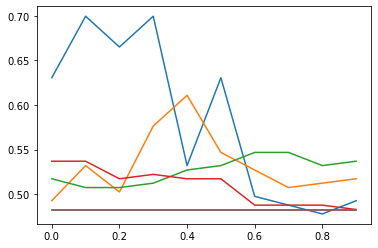

In [5]:

# for i in range(8):
#     if yacc[i]==np.nan:yacc[i]=0
#     if yFNs[i]==np.nan:yFNs[i]=0

for yACC in yconvACC:
    plt.plot(ratios, yACC)

plt.show()
# plt.legend(["R1="+str(i/8) for i in range(1,9)], loc='lower right')
# plt.show()